# Histopathologic Cancer Detection by Convolutional Neural Networks (CNNs)

### Problem Description

In this project we are trying to identify metastatic cancer in digital pathology scans using Convolutional Neural Networks (CNN) to classify the images as showing signs of tumorous cells or not. The data/contest/problem description is available at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.

The dataset has 220,025 square images 96px in size for training. There are 57,458 test images of the same size.

According to Kaggle, "A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."" e.

## 0) Setup

### Import Required Libraries

In [1]:
# Import required (and probably some unused stragglers) libraries
import pandas as pd
import numpy as np
import pandas as pd
import sklearn
import os
import itertools
import shutil
import random
import glob
import warnings
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras import initializers
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input, Dropout, ReLU, CenterCrop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from visualkeras import layered_view
from keras.regularizers import l2
import keras_tuner as kt
from sklearn.metrics import confusion_matrix
import tensorflow.python.keras.backend as K

### Data Preparation

Here we will split off some small amount of the data to a "sanity" directory. Basically, this will be a small sub-sample of the data that will allow us to sanity check what we're doing later. The idea is essentially that if we set up our models/functions/optimizers/etc. correctly, working with such a small sub-sample of the data should give very quick feedback from the model output, and also lead to a very well-performing (overfit) model to confirm that we have the ability to converge to a working estimator.

In [2]:
# The data comes separated as train and test, but we'll also split off some validation data from train for later tuning
full_train_df = pd.read_csv("./histopathologic-cancer-detection/train_labels.csv")

# First we need to pull in the training labels, and then be very careful to split off the proper validation labels
full_labels = pd.read_csv("./histopathologic-cancer-detection/train_labels.csv")['label']

NUM_SANITY = 100

if os.path.isdir('./histopathologic-cancer-detection/sanity/') is False:
    # Make the valid directory
    os.makedirs('./histopathologic-cancer-detection/sanity/')
    # Move into the train directory
    os.chdir('./histopathologic-cancer-detection/train/')
    # Move a random sample into the valid directory
    # First, enumerate over the files to help with the label split
    sanity_choices = random.sample(list(enumerate(glob.glob('*'))), NUM_SANITY)
    # Now actually move them
    for c in sanity_choices:
        shutil.move(c[1], '../sanity/')
    # Create the proper label splits given the indexes
    sanity_indexes = [c[0] for c in sanity_choices]
    sanity_labels = full_labels[sanity_indexes]
    mask = np.ones(full_labels.size, dtype=bool)
    mask[sanity_indexes] = False
    train_labels = full_labels[mask]
    # Save these to csv for stable use at later times
    np.savetxt("../sanity_labels_final.csv", sanity_labels, delimiter=",")
    np.savetxt("../train_labels_final.csv", train_labels, delimiter=",")
    # Move back to the base notebook directory
    os.chdir('../../')


##### Some checks on the previous splitting procedure

These are just some minor checks on what was done above to ensure we maintained the integrity of all the data.

In [3]:
train_dir_len = len(os.listdir('./histopathologic-cancer-detection/train/'))
sanity_dir_len = len(os.listdir('./histopathologic-cancer-detection/sanity/'))
test_dir_len = len(os.listdir('./histopathologic-cancer-detection/test/'))
print("Train Size: {}".format(train_dir_len))
print("Sanity-Check Size: {}".format(sanity_dir_len))
print("Test Size: {}".format(test_dir_len))

# Check that the validation split off is at least size-consistent
sanity_labels_df = pd.read_csv("./histopathologic-cancer-detection/sanity_labels_final.csv", sep=',', header=None)
train_labels_df = pd.read_csv("./histopathologic-cancer-detection/train_labels_final.csv", sep=',', header=None)

assert len(sanity_labels_df) == sanity_dir_len, "Sanity-Check labels are not the same size as the sanity-check directory!!"
assert len(train_labels_df) == train_dir_len, "Train labels are not the same size as the Train directory!!"

Train Size: 219925
Sanity-Check Size: 100
Test Size: 57458


## 1) Exploratory Data Analysis (EDA)

#### Data Balance

The first thing we will do is take a look at the distribution of our data to assess its "balance." For a problem of cancer research, an initial concern could be havily unbalanced data that contains much more non-cancerous than cancerous samples. However, we find that the data is relatively well balanced, with an approximate 60/40 split between Non-Cancerous and Cancerous samples. Accordingly, data balance/distribution should not be a major concern in our modelling decisions. Nevertheless, since we have a binary problem we will want to keep this split in mind and also take a look at precision and recall metrics in addition to accuracy to ensure that our model is performing meaningfully better than just a random guess.

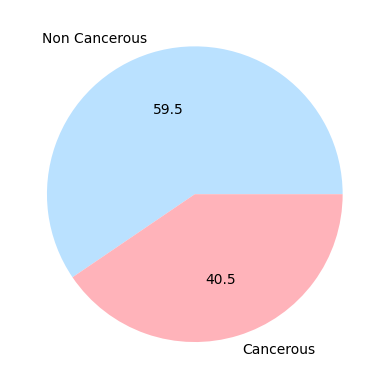

<Figure size 1600x1600 with 0 Axes>

In [4]:
labels_count = full_labels.value_counts()

plt.pie(labels_count, labels=['Non Cancerous', 'Cancerous'], autopct='%1.1f', colors=['#bae1ff','#ffb3ba'])
plt.figure(figsize=(16,16))
plt.show()

#### Data Visualization

Let's now take a look at 20 random samples from the training data. Recall that a 1 label indicates that at least one pixel in the center region shows signs of a tumor.

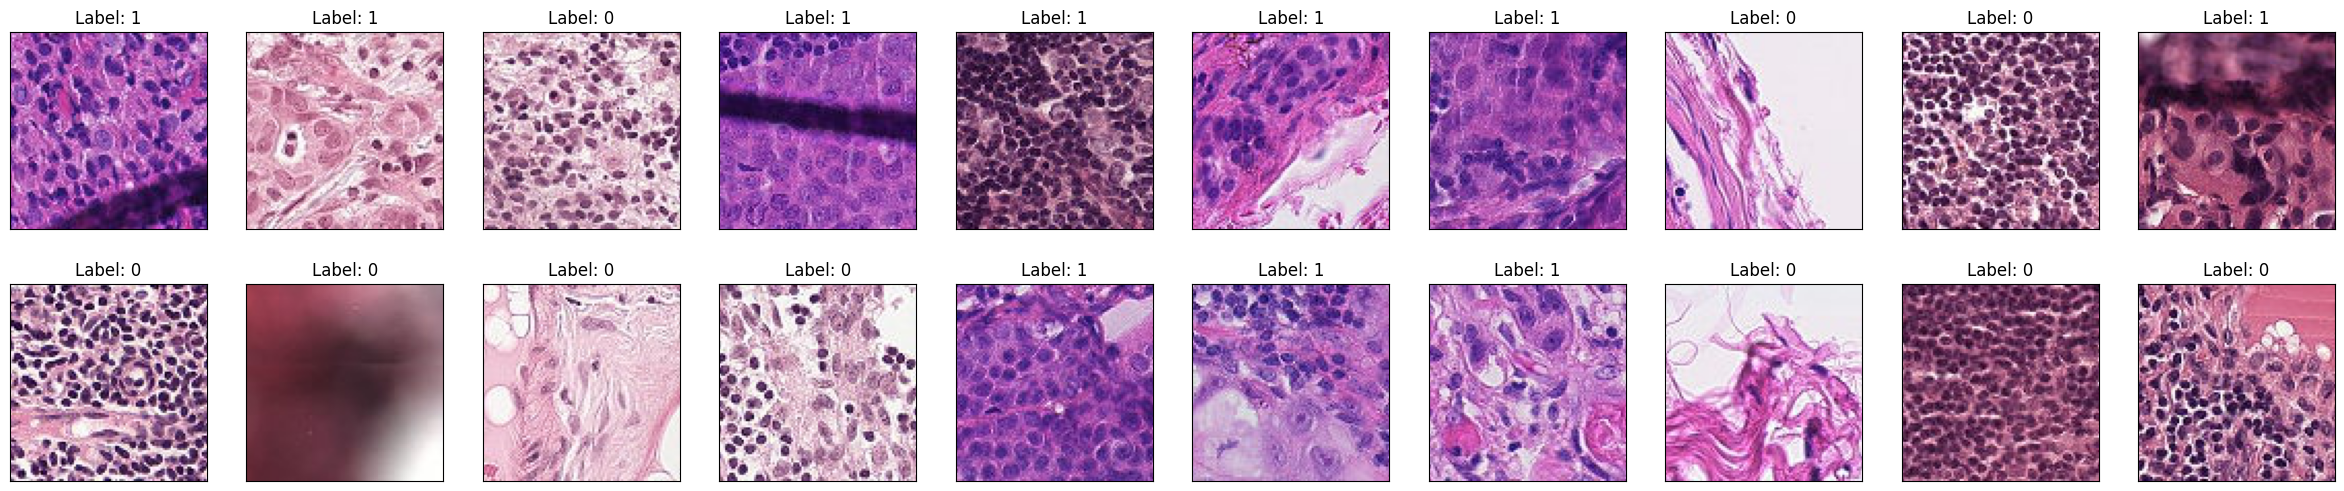

In [5]:
fig = plt.figure(figsize=(30, 6))
# display 20 images
train_imgs = os.listdir("./histopathologic-cancer-detection/train/")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = full_train_df.loc[full_train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

### Data Cleaning/Preprocessing

Now we can do some straightforward cleaning/preprocessing. Here we basically jam the data into a data structure that will be very easy to deal with later that contains the file/picture's directory location along with its label and play well with some existing Keras classes/methods for flowing data to our models. Accordingly, the labels are also converted to string in order to work with that flow_from_dataframe() method.

In [6]:
# Pull in some better dataframes of the picture id/filenames and labels
train_items = list(glob.glob('./histopathologic-cancer-detection/train/*'))
sanity_items = list(glob.glob('./histopathologic-cancer-detection/sanity/*'))
train_pairs = pd.DataFrame([(a, b) for a, b in zip(train_items, list(train_labels_df.iloc[:, 0]))], columns = ['id', 'label'])
sanity_pairs = pd.DataFrame([(a, b) for a, b in zip(sanity_items, list(sanity_labels_df.iloc[:, 0]))], columns = ['id', 'label'])

In [7]:
# The label must be converted from int64 to string to work with the flow_from_dataframe function
train_pairs['label'] = train_pairs['label'].astype(str)
sanity_pairs['label'] = sanity_pairs['label'].astype(str)
train_pairs.head()

id label
0  ./histopathologic-cancer-detection/train\00001...   0.0
1  ./histopathologic-cancer-detection/train\00002...   1.0
2  ./histopathologic-cancer-detection/train\00004...   0.0
3  ./histopathologic-cancer-detection/train\0000d...   0.0
4  ./histopathologic-cancer-detection/train\0000d...   0.0

#### Training Data Subset

To speed up training a bit and since this is more of a learning exercise than a real study/build, and since the full data offered is already so numerous, here I split off a random 50,000 pairs from the dataframe that was just created. This simply makes it feasible to play around with and run locally on an average pc/laptop while not having to wait around for hours to see if reasonable mdoel architecture has been implemented.

In [8]:
full_train_len = len(train_pairs)
training_subset = random.sample(range(full_train_len), 50000)

train_pairs_final = train_pairs.iloc[training_subset]

#### Image Normalization and Generator Initialization

Here I set up some functions that will help preprocess and normalize the data. The first function creates an ImageDataGenerator with standard-normalized values. I also set the horizontal and vertical flippings to true, since by all intuition those orientations should not be directly related to the outcome and may help the model generalize. Finally, I create the flow from dataframe, which importantly shifts us into grayscale in order to compress the third dimension of the original data. Basically I made the assumption that the RGB dimension did not matter in otder to simplify my model. I know nothing about cancerous cells so this may be a terrible assumption, but nevertheless I'm just trying to streamline this whole thing.

In [9]:
def create_datagen(validation_split, preprocessing_function=None):
    return ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        validation_split=validation_split,
        samplewise_center=True,
        samplewise_std_normalization=True,
        horizontal_flip=True,
        vertical_flip=True)

def create_flow(datagen, directory, train_pairs, x_col, y_col, target_size, batch_size, class_mode, subset):
    return datagen.flow_from_dataframe(
        dataframe=train_pairs,
        directory=train_path,
        x_col=x_col, 
        y_col=y_col,
        target_size=target_size,
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode=class_mode,
        use_multiprocessing=True,
        subset=subset,
        shuffle=False
    )

##### Now let's run through the functions created above, effectively initializing our generator, and normalizing/preprocessing our images.

In [98]:
# Image preprocessing
target_size = (96, 96) # no downsizing, at least yet
batch_size_train = 256
batch_size_sanity = 5

train_path = '.'
sanity_path = '.'

datagen = create_datagen(0.5)
trainor = create_flow(datagen, train_path, train_pairs_final, 'id', 'label', target_size, batch_size_train, 'binary', 'training')
validator = create_flow(datagen, train_path, train_pairs_final, 'id', 'label', target_size, batch_size_train, 'binary', 'validation')

sanity_trainor = create_flow(datagen, sanity_path, sanity_pairs, 'id', 'label', target_size, batch_size_sanity, 'binary', 'training')
sanity_validator = create_flow(datagen, sanity_path, sanity_pairs, 'id', 'label', target_size, batch_size_sanity, 'binary', 'validation')

Found 25000 validated image filenames belonging to 2 classes.
Found 25000 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.


##### Here let's take a quick peak at what some images look like after all of this preprocessing.

In [11]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

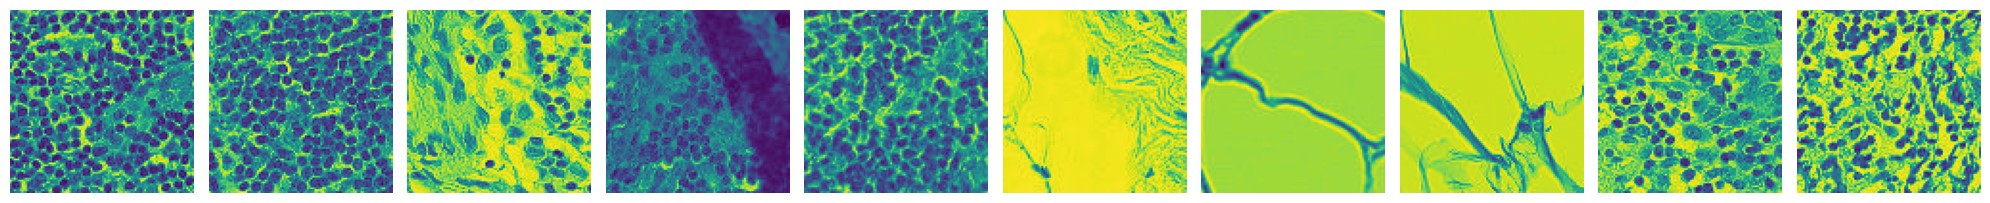

In [12]:
imgs, labels = next(trainor)
plotImages(imgs)

## 2) Model Building and Fitting

In [13]:
# Quick function to reinitialize weights that may come in handy for manual tuned re-reruns of the same model.
def reinitialize(model):
    sess = K.get_session()
    for layer in model_1.layers:
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))

Now we can start building and training an actual CNN. I start by building a Keras Sequential model below. For the sake of this exercise I had an eye to keeping the number of parameters low so that training times would be reasonable, so this is likely far from an ideal/optimal architecture. A final summary of the model is shown a few cells below. This particular architecture results in about 145,000 parameters (the vast majority of these come in the dense layers of the post-convolution neural network). The first convolution layer uses a larger kernel with no padding due to the fact that the focus of the analysis is really on the 32 center pixels of the image, so the loss of information at the edges could be justified. These filters are then pooled and normalized. A second convolution layer performs something similar but with a typically smaller kernel. From there, I flatten the result and build a fairly standard neural network with three hidden layers and finally sigmoid the result to get a classifier (could have easily used softmax here but since this is binary it achieves the same result).

In [89]:
model_1 = Sequential([
    Input(shape = (96, 96, 1)),

    # Convolution Layer 1
    Conv2D(filters=8, kernel_size=(17, 17), padding='valid', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(3, 3), padding='same'),
    BatchNormalization(),

    # Convolution Layer 2
    Conv2D(filters=6, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(3, 3), padding='same'),
    BatchNormalization(),

    # Neural Network/Classifier Layer
    Flatten(),
    Dense(256),
    ReLU(),
    Dense(64),
    ReLU(),
    Dense(16),
    ReLU(),
    Dense(1, activation='sigmoid'),
])

In [90]:
# Compile and prepare model for training
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics = ['accuracy', 'precision', 'recall'])

In [91]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 80, 80, 8)           │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 80, 80, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 27, 27, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 27, 27, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 6)           │             438 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_6 (ReLU)                       │ (None, 27, 27, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 6)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 9, 6)             │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 486)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         124,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_7 (ReLU)                       │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_8 (ReLU)                       │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,991 (566.37 KB)

 Trainable params: 144,963 (566.26 KB)

 Non-trainable params: 28 (112.00 B)

In [92]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, start_from_epoch=5)

#### Fit the sanity check model

Recall we really expect the accuracy to get to 100% since the "sanity" dataset is so small. This is effectively just a test to make sure that we set everything above up properly, and our model can converge during training.

In [93]:
# Re-initialize the weights of the model
reinitialize(model_1)

# Fit the sanity check model (recall we really expect accuracy to get to 100% since the dataset is so small!!)
sanity_log = model_1.fit(x=sanity_trainor, 
                         validation_data=sanity_validator, 
                         epochs=50, 
                         verbose=2,
                         )

Epoch 1/50
10/10 - 2s - 232ms/step - accuracy: 0.4200 - loss: 0.7120 - precision: 0.4444 - recall: 0.6400 - val_accuracy: 0.5000 - val_loss: 0.8729 - val_precision: 0.4333 - val_recall: 0.6190
Epoch 2/50
10/10 - 0s - 18ms/step - accuracy: 0.5200 - loss: 0.7441 - precision: 0.5263 - recall: 0.4000 - val_accuracy: 0.3800 - val_loss: 1.3356 - val_precision: 0.3913 - val_recall: 0.8571
Epoch 3/50
10/10 - 0s - 20ms/step - accuracy: 0.6800 - loss: 0.5219 - precision: 0.7143 - recall: 0.6000 - val_accuracy: 0.4200 - val_loss: 0.9369 - val_precision: 0.4048 - val_recall: 0.8095
Epoch 4/50
10/10 - 0s - 19ms/step - accuracy: 0.8400 - loss: 0.4278 - precision: 0.8400 - recall: 0.8400 - val_accuracy: 0.6000 - val_loss: 0.7879 - val_precision: 0.5135 - val_recall: 0.9048
Epoch 5/50
10/10 - 0s - 19ms/step - accuracy: 0.8600 - loss: 0.4189 - precision: 0.8462 - recall: 0.8800 - val_accuracy: 0.6400 - val_loss: 0.7498 - val_precision: 0.5600 - val_recall: 0.6667
Epoch 6/50
10/10 - 0s - 18ms/step - acc

The sanity check model seems to have worked, so let's set up a function and take a look at all the metrics. The sanity training set certainly shows the behavior we would expect. It is left to see of the model generalizes well to the validation set when we train it on the larger subset of data shortly.

In [103]:
def plot_metric(training_log, metric_name, title):
    plt.plot(training_log.history[metric_name])
    plt.plot(training_log.history['val_' + metric_name])
    plt.title('Model ' + metric_name)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.title(title)
    plt.show()

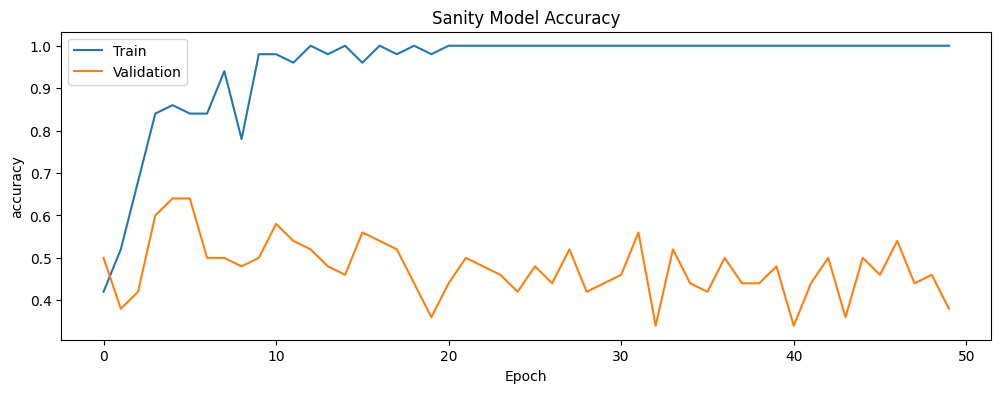

In [104]:
plt.figure(figsize=(12, 4))
plot_metric(sanity_log, 'accuracy', 'Sanity Model Accuracy')

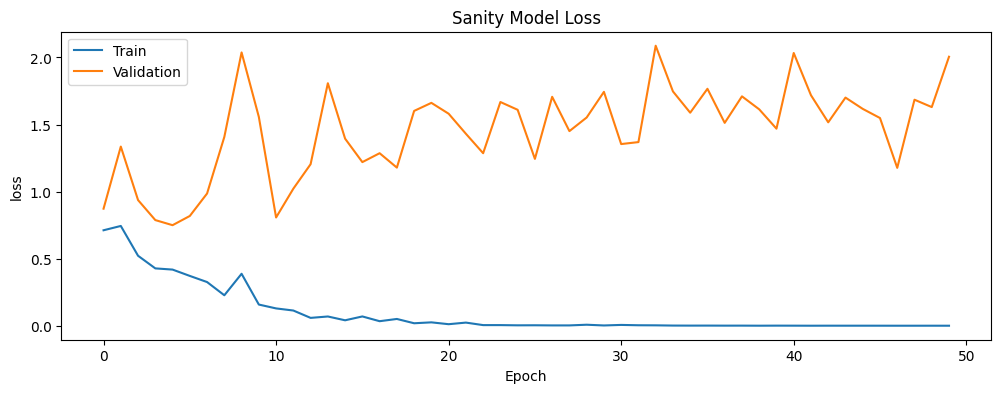

In [105]:
plt.figure(figsize=(12, 4))
plot_metric(sanity_log, 'loss', 'Sanity Model Loss')

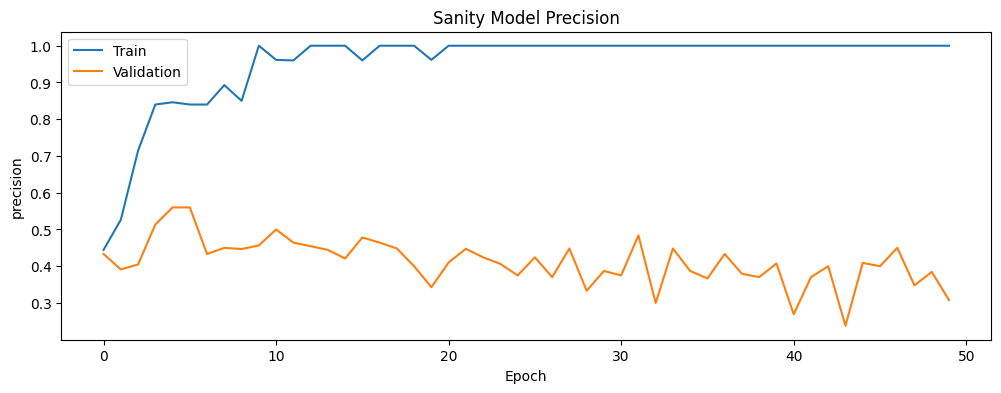

In [106]:
plt.figure(figsize=(12, 4))
plot_metric(sanity_log, 'precision', 'Sanity Model Precision')

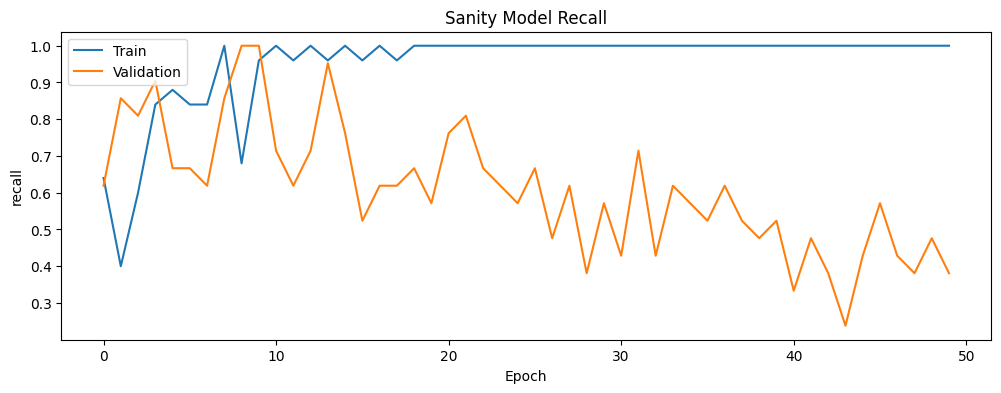

In [107]:
plt.figure(figsize=(12, 4))
plot_metric(sanity_log, 'recall', 'Sanity Model Recall')

#### Fit the real training models

Now let's train the real model on the full (recall not really full, we split off 50,000 samples for time reasons...) data. We'll importantly look out for both training convergence but also validation results (possible overfitting). We will tune the model later to deal with these observations.

In [111]:
# Re-initialize the weights of the model
reinitialize(model_1)

# Fit
training_log = model_1.fit(x=trainor, 
                        validation_data=validator, 
                        epochs=50, 
                        verbose=1,
                        )

Epoch 1/50


C:\Users\zackp\AppData\Roaming\Python\Python39\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.5584 - loss: 0.6990 - precision: 0.4064 - recall: 0.2152 - val_accuracy: 0.5943 - val_loss: 0.6784 - val_precision: 0.3854 - val_recall: 0.0120
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 437ms/step - accuracy: 0.5957 - loss: 0.6758 - precision: 0.5365 - recall: 0.0190 - val_accuracy: 0.5947 - val_loss: 0.6787 - val_precision: 0.4184 - val_recall: 0.0158
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - accuracy: 0.6040 - loss: 0.6687 - precision: 0.5212 - recall: 0.0158 - val_accuracy: 0.5950 - val_loss: 0.6786 - val_precision: 0.3955 - val_recall: 0.0105
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 434ms/step - accuracy: 0.6026 - loss: 0.6675 - precision: 0.5136 - recall: 0.0170 - val_accuracy: 0.5928 - val_loss: 0.6789 - val_precision: 0.3864 - val_recall: 0.0186
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 443ms/step - accuracy: 0.6001 - loss: 0.6654 - precision: 0.5858 - recall: 0.0281 - val_accuracy: 0.5933 - val_loss: 0.6787 - v

##### Looking at the metric plots below, while we are getting decent convergence (and certainly meaningfully better than just a random guess), this model is clearly overfitting! For now, we won't go back and look for a simpler/generalizable model by hand, but rather move straight on to hyperparameter tuning.

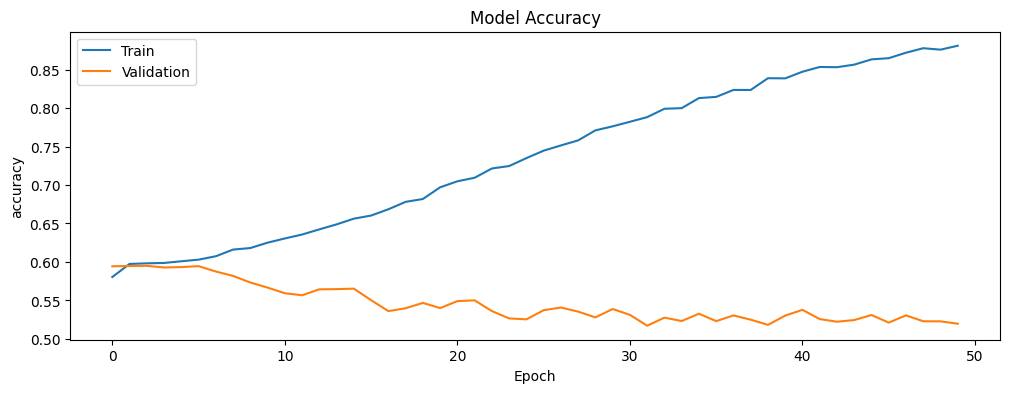

In [112]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'accuracy', 'Model Accuracy')

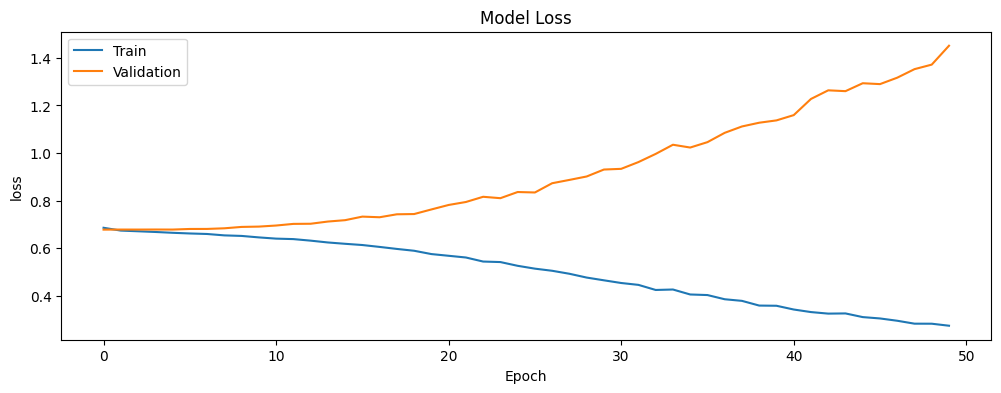

In [113]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'loss', 'Model Loss')

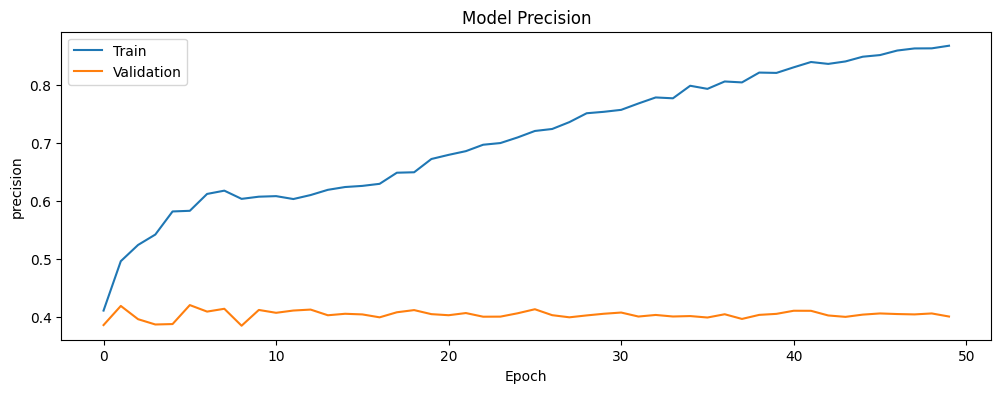

In [114]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'precision', 'Model Precision')

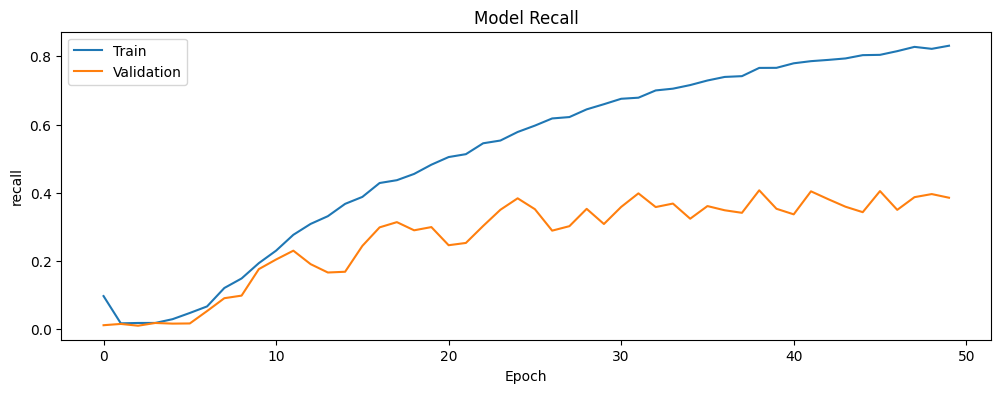

In [115]:
plt.figure(figsize=(12, 4))
plot_metric(training_log, 'recall', 'Model Recall')

#### Tuning the model

As mentioned above, our model appears to be overfitting to the training data. With that in mind, now we'll tune some of the hyperparameters of the model using the Keras tuner, focusing on improving the validation metrics. The overall architecture of the model will be the same, and we'll search for optimal filter and kernel sizes. In addition, I'm going to add a kernel regularizer/penalty to the Dense layers (just as a note on the way these layer classes work - anything can be regularized, even the convolution layers, but since the overwhelming majority of parameters are in the dense layers, I focus the regularization there. I could have additionally used Dropout layers, but will refrain from that now and maybe play around with it at a later time).

In [116]:
def build_model(hp):
  model = Sequential([
        Input(shape = (96, 96, 1)),

        # Convolution Layer 1
        Conv2D(filters=hp.Int("conv_filters1", min_value=6, max_value=10, step=1), padding='valid', kernel_size=hp.Int("kernel_size1", 13, 65), kernel_initializer=initializers.HeNormal()),
        ReLU(),
        MaxPool2D(pool_size=(2, 2), padding='same'),
        BatchNormalization(),

        # Convolution Layer 2
        Conv2D(filters=hp.Int("conv_filters2", min_value=3, max_value=5, step=1), padding='same', kernel_size=hp.Int("kernel_size2", 3, 13), kernel_initializer=initializers.HeNormal()),
        ReLU(),
        MaxPool2D(pool_size=(2, 2), padding='same'),
        BatchNormalization(),

        # Neural Network/Classifier Layer
        Flatten(),
        Dense(hp.Int("dense_nodes1", min_value=128, max_value=384, step=16), kernel_regularizer=l2(0.001)),
        ReLU(),
        Dense(hp.Int("dense2", min_value=24, max_value=64, step=8), kernel_regularizer=l2(0.001)),
        ReLU(),
        Dense(hp.Int("dense2", min_value=8, max_value=16, step=4), kernel_regularizer=l2(0.001)),
        ReLU(),
        #Dropout(hp.Float("dropout1", min_value=0.15, max_value=0.6, step=0.025)),
        Dense(1, activation='sigmoid'),
    ])
  model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0005, 0.0001, 0.00005, 0.00001])), loss='binary_crossentropy', metrics = ['accuracy', 'precision', 'recall'])
  return model

In [117]:
tuner = kt.RandomSearch(
    build_model,
    overwrite=True,
    objective='val_loss',
    max_trials=25)

In [118]:
tuner.search(trainor, epochs=10, validation_data=validator)

Trial 25 Complete [00h 14m 41s]
val_loss: 0.6897068023681641

Best val_loss So Far: 0.6831409335136414
Total elapsed time: 05h 40m 15s


In [119]:
best_model = tuner.get_best_models()[0]

C:\Users\zackp\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Let's take a look at the summary of the optimized (not really probably, I did a rather small number of trials and epochs here to get results back faster) model. The main takeaways are that it is using a much larger kernel size in the fisrt convolutional layer, as well as a denser first layer on the post-convolution neural network. This model ends up having over 437,000 parameters.

In [120]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 69, 69, 6)           │           4,710 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 69, 69, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 35, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 35, 35, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 35, 35, 4)           │           3,460 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 35, 35, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 18, 18, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 18, 4)           │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1296)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 320)                 │         415,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │          12,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437,771 (1.67 MB)

 Trainable params: 437,751 (1.67 MB)

 Non-trainable params: 20 (80.00 B)

#### Tuned Model Clone and Results Analysis

Here I just recreate the tuned model so that I can train it and analyze the metrics we looked at before (accuracy, loss, precision, recall). Oddly the model appears to be even more overfit than before, even though the tuning was supposed to target the validation set. The only metric showing desired behavior on the validation set over the epochs is recall. So, either my architecture is just too complicated in general, or I am doing something wrong somewhere that I will have to investigate further later.

In [147]:
best_model_clone = Sequential([
    Input(shape = (96, 96, 1)),

    # Convolution Layer 1
    Conv2D(filters=6, kernel_size=(28, 28), padding='valid', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    BatchNormalization(),

    # Convolution Layer 2
    Conv2D(filters=4, kernel_size=(3, 3), padding='same', kernel_initializer=initializers.HeNormal()),
    ReLU(),
    MaxPool2D(pool_size=(2, 2), padding='same'),
    BatchNormalization(),

    # Neural Network/Classifier Layer
    Flatten(),
    Dense(320),
    ReLU(),
    Dense(40),
    ReLU(),
    Dense(40),
    ReLU(),
    Dense(1, activation='sigmoid'),
])

# Compile and prepare model for training
best_model_clone.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics = ['accuracy', 'precision', 'recall'])
best_model_clone.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 69, 69, 6)           │           4,710 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_25 (ReLU)                      │ (None, 69, 69, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 35, 35, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 35, 35, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 35, 35, 4)           │             220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_26 (ReLU)                      │ (None, 35, 35, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 18, 18, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 18, 18, 4)           │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1296)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 320)                 │         415,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_27 (ReLU)                      │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 40)                  │          12,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_28 (ReLU)                      │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_29 (ReLU)                      │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 434,531 (1.66 MB)

 Trainable params: 434,511 (1.66 MB)

 Non-trainable params: 20 (80.00 B)

In [148]:
# Re-initialize the weights of the model
reinitialize(best_model_clone)

# Fit
best_log = best_model_clone.fit(x=trainor, 
                        validation_data=validator, 
                        epochs=50, 
                        verbose=1,
                        )

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.5611 - loss: 0.6953 - precision: 0.3975 - recall: 0.1742 - val_accuracy: 0.5873 - val_loss: 0.6901 - val_precision: 0.3967 - val_recall: 0.0473
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 707ms/step - accuracy: 0.5919 - loss: 0.6755 - precision: 0.4458 - recall: 0.0842 - val_accuracy: 0.5882 - val_loss: 0.6832 - val_precision: 0.4028 - val_recall: 0.0463
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 68s 681ms/step - accuracy: 0.6004 - loss: 0.6716 - precision: 0.4785 - recall: 0.0547 - val_accuracy: 0.5832 - val_loss: 0.6821 - val_precision: 0.4093 - val_recall: 0.0782
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 68s 684ms/step - accuracy: 0.5958 - loss: 0.6690 - precision: 0.5717 - recall: 0.0939 - val_accuracy: 0.5923 - val_loss: 0.6831 - val_precision: 0.4323 - val_recall: 0.0390
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 677ms/step - accuracy: 0.6047 - loss: 0.6624 - precision: 0.5579 - recall: 0.0720 - val_accuracy: 0.5864 - val_loss:

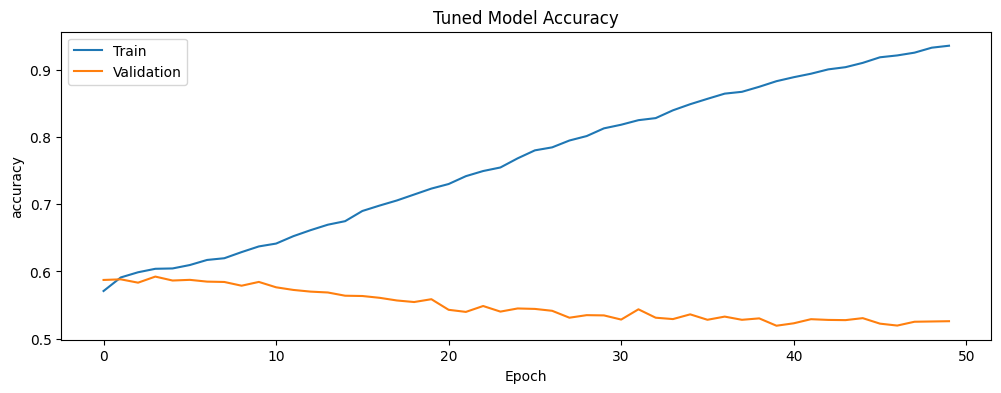

In [149]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'accuracy', 'Tuned Model Accuracy')

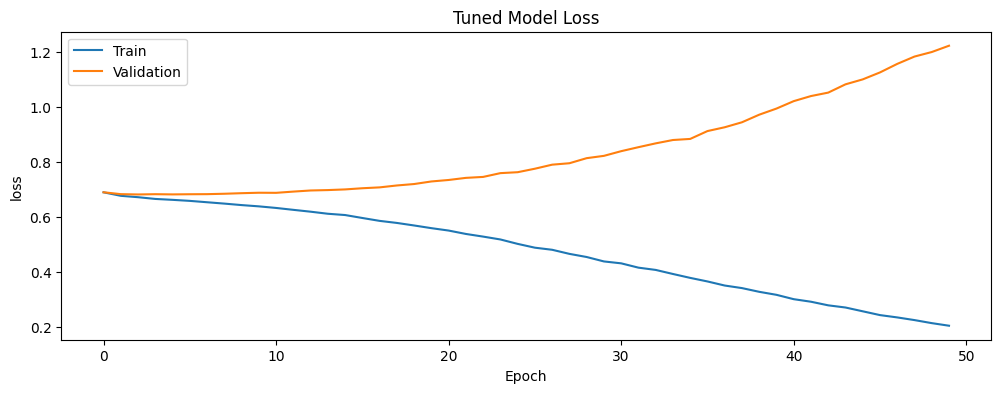

In [150]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'loss', 'Tuned Model Loss')

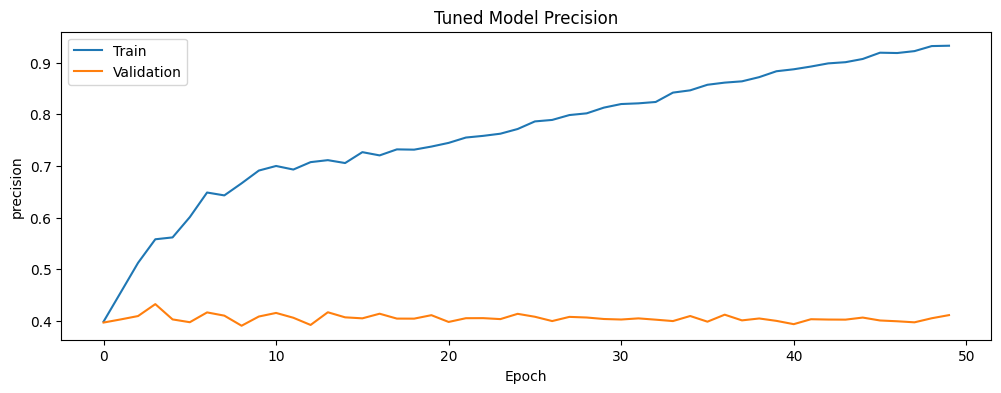

In [151]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'precision', 'Tuned Model Precision')

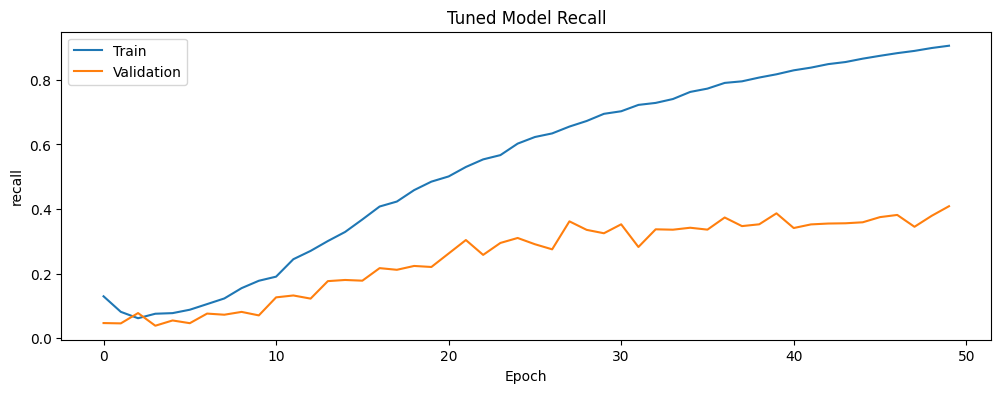

In [152]:
plt.figure(figsize=(12, 4))
plot_metric(best_log, 'recall', 'Tuned Model Recall')

## 3) Testing/Predictions

Now I simply take the best model from training and use it for prediction on the testing set. I'll then submit the results to the Kaggle competition to wrap up this project.

In [140]:
test_dir = './histopathologic-cancer-detection/test/'

test_files = os.listdir(test_dir)
test_dataframe = pd.DataFrame(test_files, columns=['id'])

test_datagen = create_datagen(None) # Since testing, NO validation split

def create_test_flow(datagen, dataframe, directory, x_col, target_size, batch_size):
    return datagen.flow_from_dataframe(
         dataframe=test_dataframe,
         directory=directory,
         x_col=x_col, 
         y_col=None,
         target_size=target_size,
         color_mode='grayscale',
         batch_size=batch_size,
         class_mode=None,
         use_multiprocessing=True
     )

testor = create_test_flow(test_datagen, test_dataframe, test_dir, 'id', target_size, batch_size_train)

Found 57458 validated image filenames.


In [141]:
predictions = best_model.predict(testor)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(test_dataframe)}")
binary_predictions = (predictions >= 0.5).astype(int).flatten() # convert the sigmoid 0-1 to either 0 or 1
print(len(binary_predictions))
submission_dataframe = pd.DataFrame()
submission_dataframe['id'] = test_dataframe['id'].apply(lambda x: x.split('.')[0]) # remove .tif from the id
submission_dataframe['label'] = binary_predictions
submission_dataframe.to_csv('submission.csv', index=False)

225/225 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step
Number of predictions: 57458
Number of test samples: 57458
57458


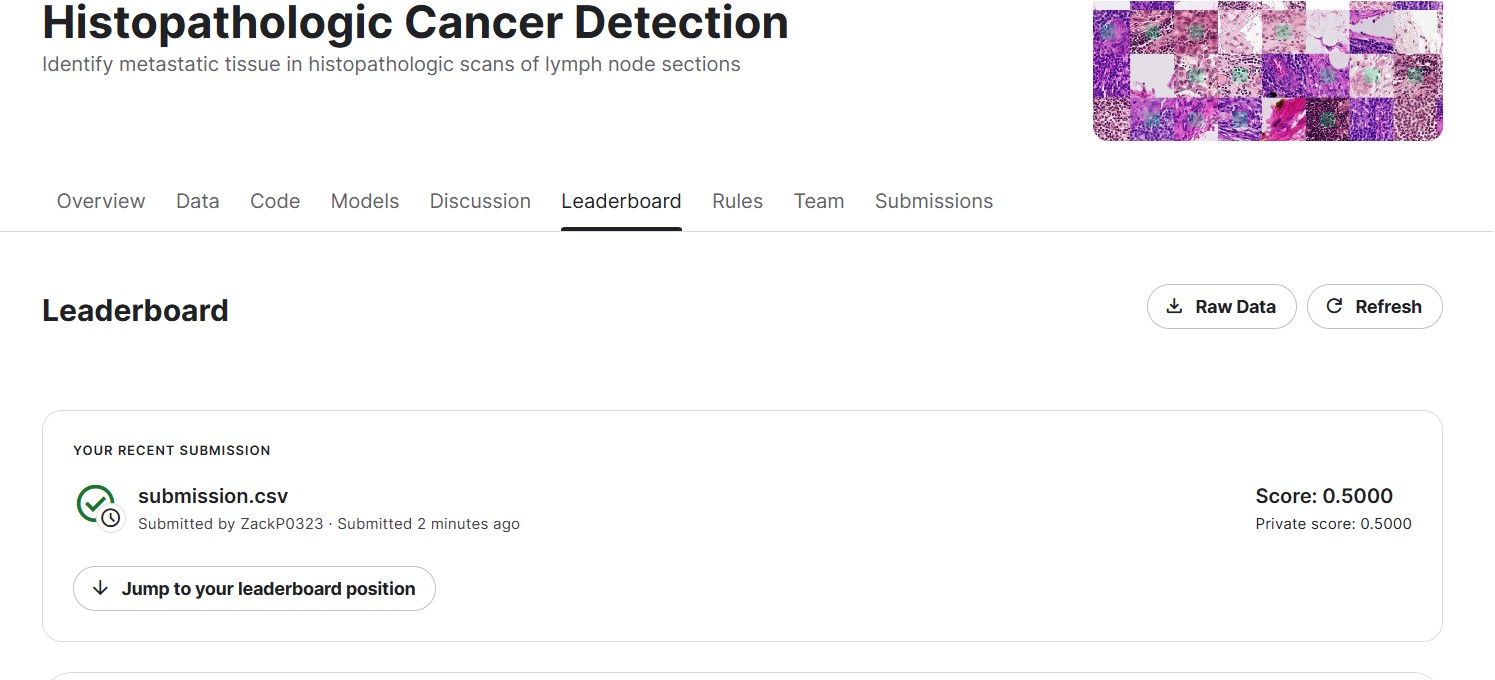

In [153]:
from PIL import Image
pil_im = Image.open('Leaderboard_Screenshot.jpg')
display(pil_im)